In [1]:
import os
import pickle
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from tensorflow.keras.utils import to_categorical, plot_model
from keras_layer_normalization import LayerNormalization
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report 
data_path = 'Images_Min/'        

In [2]:
# load data
targets = []
images = []
for folder in sorted(os.listdir(data_path)):
    for file in os.listdir(data_path+folder):
        targets.append(str (folder))
        image = Image.open(data_path+folder+'/'+file)
        images.append(np.array(image))
        

Text(0.5, 1.0, 'Sanas')

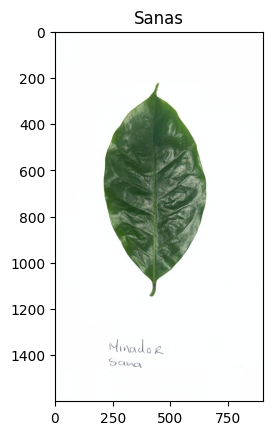

In [3]:
# check example image
idx = np.random.choice(len(images))
plt.imshow(images[idx])
plt.title(targets[idx])

In [4]:
# check example image
data = tf.keras.utils.image_dataset_from_directory('Images_Min/')
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

Found 200 files belonging to 2 classes.


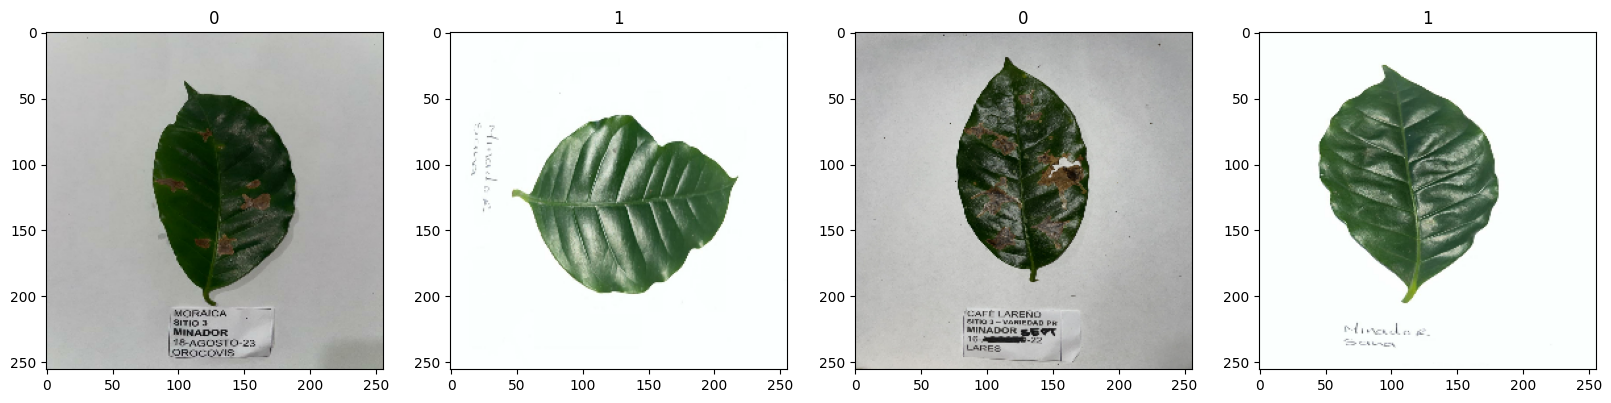

In [5]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [6]:
#preprocessing images
# functions for cropping images

def mask_leaf(image_array, threshold=0.05):
    """ Returns a boolean array of shape n_rows x n_cols x 1
        where True pixels are estimated to contain the leaf
    """
    
    shape = image_array.shape
    
    # Extract the Red, Green, and Blue channels
    red_channel = image_array[:, :, 0]
    green_channel = image_array[:, :, 1]
    blue_channel = image_array[:, :, 2]
    
    # Calculate the maximum value between the Red and Blue channels
    max_other_channels = np.maximum(red_channel, blue_channel)
    
    # Find pixels where the Green channel is at least 20% higher than max of Red and Blue
    mask = green_channel >= (1+threshold) * max_other_channels
    
    # Convert the mask to a uint8 array (0 for False, 1 for True)
    mask = mask.astype(np.uint8)
    
    # Reshape the mask
    mask = mask.reshape(shape[0], shape[1], 1)
    
    return mask

def crop_leaf(image_array):
    """ #Estimates the bounding box of a leaf based on mask_leaf results and crops the image
    """
    mask = mask_leaf(image_array)
    
    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    areas = []
    for i in contours:
        areas.append(cv2.contourArea(i))
    largest_contour = contours[np.argmax(areas)]
    
    if len(contours) == 0:
        print("No leaf found in the image.")
        return None

    # Get the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the image using the bounding box coordinates
    cropped_image = image_array[y:y+h, x:x+w]
    
    return cropped_image

# run
image_size = (128, 128) # for resizing images
for c,i in enumerate(images):
    image = crop_leaf(np.array(i))
    image = Image.fromarray(image)
    image = image.resize(image_size) # resize
    images[c] = image


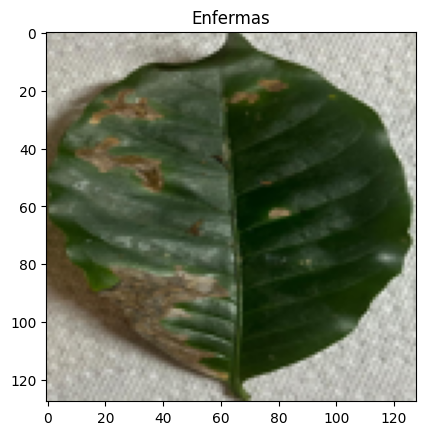

In [7]:
# check processed example
plt.imshow(images[idx])
plt.title(targets[idx]);

In [ ]:
#convierto de lista a numpy array
y = np.array(targets)
X = np.array(images) 
 

In [12]:
#Dividir los datos en entrenamiento y testing
x_train,x_test,y_train,y_test= train_test_split(X,y, test_size=0.2, shuffle=True)
print('Training data shape : ', x_train.shape, y_train.shape)
print('Testing data shape : ', x_test.shape, y_test.shape)


Training data shape :  (160, 128, 128, 3) (160,)
Testing data shape :  (40, 128, 128, 3) (40,)


In [13]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
#normalizacion de la imgenes para que tengan valores de 0 a 1
x_train = x_train / 255. 
x_test = x_test / 255.

In [14]:
#Change the labels
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
train_Y_one_hot = encoder.fit_transform(y_train)
test_Y_one_hot  = encoder.fit_transform(y_test)

#Display the change for category label using one-hot encoding
print('Original label:', y_train[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: Sanas
After conversion to one-hot: 1


In [ ]:
train_Y_one_hot

array([1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 1])

In [ ]:
test_Y_one_hot

array([1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1])

In [15]:
#set de entrenamiento y set de validacion 

train_x,valid_x,train_y,valid_y = train_test_split(x_train, train_Y_one_hot, test_size=0.2,  shuffle=True)

print(train_x.shape,valid_x.shape,train_y.shape,valid_y.shape)

(128, 128, 128, 3) (32, 128, 128, 3) (128,) (32,)


In [16]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from keras.models import Sequential
from keras.models import Model
from keras.layers import Input

from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from keras.layers import  LeakyReLU

In [17]:
model = Sequential()
# conv 1
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(128, 128,3)))
model.add(MaxPooling2D())
model.add(BatchNormalization())

# conv 2
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())


# conv 3
model.add(Conv2D(64, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

#top (the fully connected layer)
model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation= 'sigmoid'))  

c:\Users\dinan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [18]:
model.compile('adam',  loss=tf.losses.BinaryCrossentropy(),  metrics=['accuracy'])

In [19]:
Model_train = model.fit(train_x, train_y, validation_data = (valid_x, valid_y),  epochs=50,  batch_size=32,  verbose=2)

Epoch 1/50
4/4 - 3s - 669ms/step - accuracy: 0.5547 - loss: 2.7387 - val_accuracy: 0.4375 - val_loss: 0.6515
Epoch 2/50
4/4 - 0s - 117ms/step - accuracy: 0.6406 - loss: 0.8110 - val_accuracy: 0.4062 - val_loss: 1.2753
Epoch 3/50
4/4 - 0s - 108ms/step - accuracy: 0.8438 - loss: 0.2850 - val_accuracy: 0.4062 - val_loss: 1.2278
Epoch 4/50
4/4 - 0s - 105ms/step - accuracy: 0.9922 - loss: 0.0628 - val_accuracy: 0.4062 - val_loss: 1.2338
Epoch 5/50
4/4 - 0s - 103ms/step - accuracy: 0.9062 - loss: 0.1593 - val_accuracy: 0.4062 - val_loss: 1.9486
Epoch 6/50
4/4 - 0s - 106ms/step - accuracy: 0.9922 - loss: 0.0176 - val_accuracy: 0.4062 - val_loss: 2.7511
Epoch 7/50
4/4 - 0s - 104ms/step - accuracy: 0.9922 - loss: 0.0405 - val_accuracy: 0.4062 - val_loss: 3.0369
Epoch 8/50
4/4 - 0s - 104ms/step - accuracy: 0.9922 - loss: 0.0184 - val_accuracy: 0.4062 - val_loss: 2.8736
Epoch 9/50
4/4 - 0s - 105ms/step - accuracy: 1.0000 - loss: 8.6632e-04 - val_accuracy: 0.4062 - val_loss: 2.6461
Epoch 10/50
4/4

In [ ]:
Y_pred =model.predict(x_test)
print('Confusion Matrix')
print(confusion_matrix(test_Y_one_hot, Y_pred.round()))


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Confusion Matrix
[[20  3]
 [ 0 17]]


In [22]:
conf_matrix = confusion_matrix(test_Y_one_hot, Y_pred.round(), labels=[0,1])
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[20  3]
 [ 0 17]]


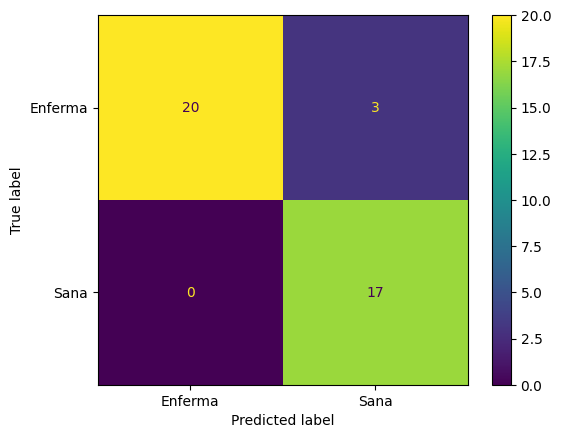

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
labels = ['Enferma', 'Sana']
ConfusionMatrixDisplay.from_predictions (test_Y_one_hot, Y_pred.round(), display_labels=labels)


In [25]:
class_report = classification_report(test_Y_one_hot, Y_pred.round())
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        23
           1       0.85      1.00      0.92        17

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.94      0.93      0.93        40



In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Exactitud:', accuracy_score(test_Y_one_hot, Y_pred.round()))
print('Precision:', precision_score(test_Y_one_hot, Y_pred.round()))
print('Recall:', recall_score(test_Y_one_hot, Y_pred.round()))
print('F1 score:', f1_score(test_Y_one_hot, Y_pred.round()) )


Exactitud: 0.925
Precision: 0.85
Recall: 1.0
F1 score: 0.918918918918919


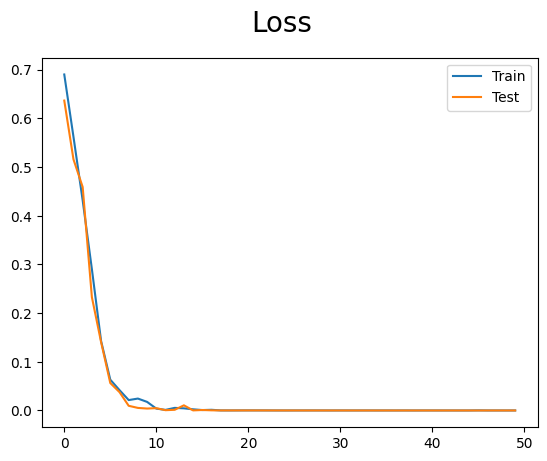

In [ ]:
fig = plt.figure()
plt.plot(Model_train.history['loss'], label='Train')
plt.plot(Model_train.history['val_loss'], label='Test')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.legend();

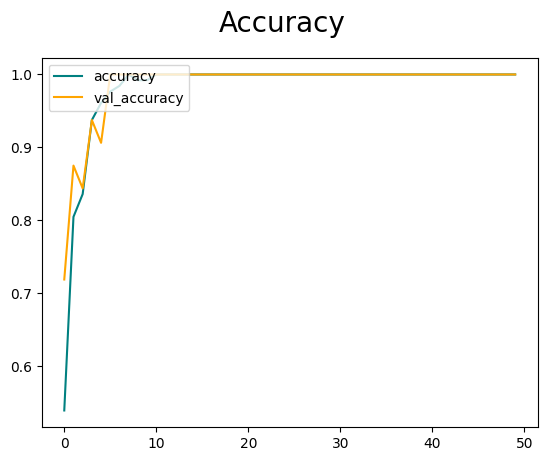

In [ ]:
fig = plt.figure()
plt.plot(Model_train.history['accuracy'], color='teal', label='accuracy')
plt.plot(Model_train.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()


In [ ]:
test_eval = model.evaluate(x_test, test_Y_one_hot , verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 5.29529461346101e-05
Test accuracy: 1.0


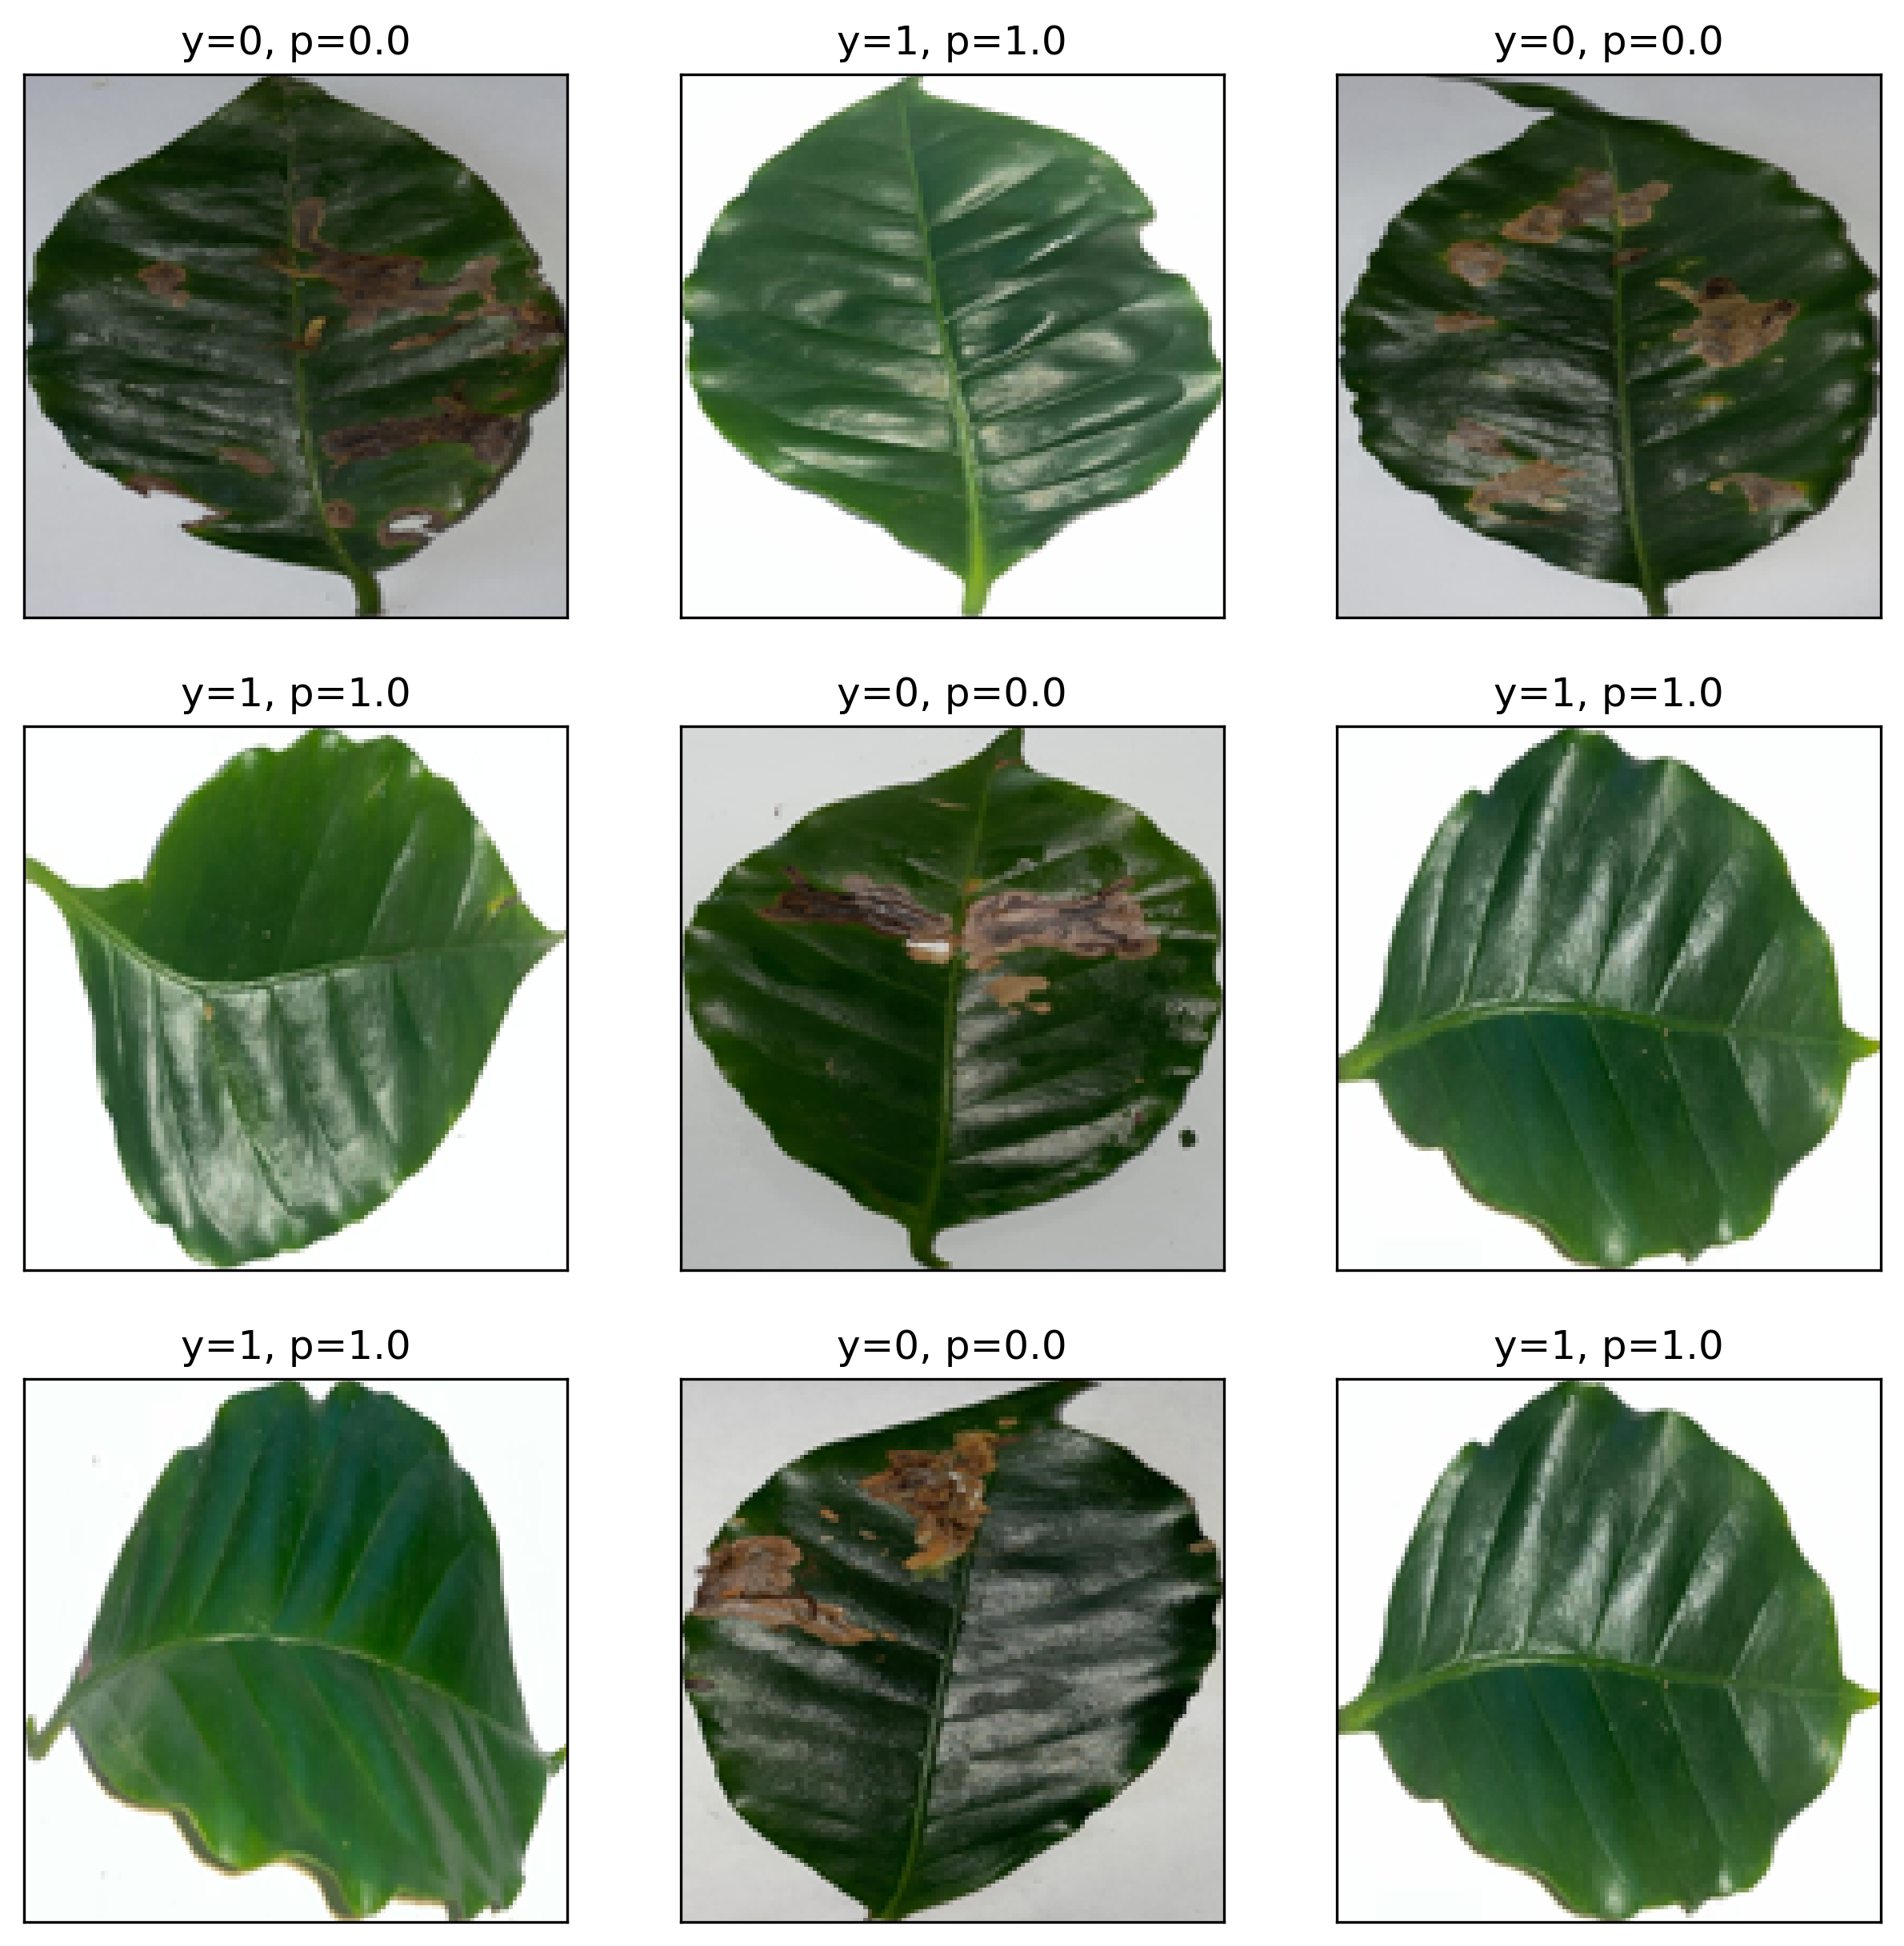

In [ ]:
# check some random predictions
nr = 3
nc = 3
idx = np.random.choice(len(x_test), nr*nc) # get random samples
plt.figure(figsize=(10, 10), dpi=300)
for i in range(nr*nc):
    p = model.predict(x_test [idx[i]:idx[i]+1], verbose=0)[0][0]
    y = test_Y_one_hot [idx[i]]
    ax = plt.subplot(nr, nc, i+1)
    ax.imshow(x_test[idx[i]])
    plt.title('y='+str(round(y, 2))+', p='+str(round(p, 2)))
    plt.xticks([])
    plt.yticks([])